In [1]:
import os

# slightly faster improvements, on the first epoch 30 second decrease and a 1-2 second
# decrease in epoch time. Overall saves approx. 5 min of training time

# Allocates two threads for a gpu private which allows more operations to be
# done faster
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"

import tensorflow as tf  # framework
from tensorflow import keras  # for tf.keras
import tensorflow_addons as tfa  # LAMB optimizer and gaussian_blur_2d function
import numpy as np  # np.random.random
import matplotlib.pyplot as plt  # graphs
import datetime  # tensorboard logs naming

# XLA optimization for faster performance(up to 10-15 minutes total time saved)
tf.config.optimizer.set_jit(True)

In [2]:
[
    (train_features, train_labels),
    (test_features, test_labels),
] = keras.datasets.cifar10.load_data()

train_features = train_features / 255.0
test_features = test_features / 255.0

In [3]:

BATCH_SIZE = 512
IMAGE_SIZE = 32

In [4]:
class Augmentation(keras.layers.Layer):
    def __init__(self):
        super(Augmentation, self).__init__()

    @tf.function
    def random_execute(self, prob: float) -> bool:
        return tf.random.uniform([], minval=0, maxval=1) < prob


class RandomToGrayscale(Augmentation):
    @tf.function
    def call(self, x: tf.Tensor) -> tf.Tensor:
        if self.random_execute(0.2):
            x = tf.image.rgb_to_grayscale(x)
            x = tf.tile(x, [1, 1, 3])
        return x


class RandomColorJitter(Augmentation):

    @tf.function
    def call(self, x: tf.Tensor) -> tf.Tensor:

        if self.random_execute(0.8):
            x = tf.image.random_brightness(x, 0.8)
            x = tf.image.random_contrast(x, 0.4, 1.6)
            x = tf.image.random_saturation(x, 0.4, 1.6)
            x = tf.image.random_hue(x, 0.2)
        return x


class RandomFlip(Augmentation):

    @tf.function
    def call(self, x: tf.Tensor) -> tf.Tensor:

        if self.random_execute(0.5):
            x = tf.image.random_flip_left_right(x)
        return x


class RandomResizedCrop(Augmentation):
    def __init__(self, image_size):
        super(Augmentation, self).__init__()
        self.image_size = image_size

    def call(self, x: tf.Tensor) -> tf.Tensor:

        rand_size = tf.random.uniform(
            shape=[],
            minval=int(0.75 * self.image_size),
            maxval=1 * self.image_size,
            dtype=tf.int32,
        )

        crop = tf.image.random_crop(x, (rand_size, rand_size, 3))
        crop_resize = tf.image.resize(crop, (self.image_size, self.image_size))
        return crop_resize


class RandomSolarize(Augmentation):
    @tf.function
    def call(self, x: tf.Tensor) -> tf.Tensor:

        if self.random_execute(0.2):
            # flips abnormally low pixels to abnormally high pixels
            x = tf.where(x < 10, x, 255 - x)
        return x


class RandomBlur(Augmentation):

    @tf.function
    def call(self, x: tf.Tensor) -> tf.Tensor:
        if self.random_execute(0.2):
            s = np.random.random()
            return tfa.image.gaussian_filter2d(image=x, sigma=s)
        return x


class RandomAugmentor(keras.Model):

    def __init__(self, image_size: int):
        super(RandomAugmentor, self).__init__()

        self.image_size = image_size
        self.random_resized_crop = RandomResizedCrop(image_size)
        self.random_flip = RandomFlip()
        self.random_color_jitter = RandomColorJitter()
        self.random_blur = RandomBlur()
        self.random_to_grayscale = RandomToGrayscale()
        self.random_solarize = RandomSolarize()

    def call(self, x: tf.Tensor) -> tf.Tensor:
        x = self.random_resized_crop(x)
        x = self.random_flip(x)
        x = self.random_color_jitter(x)
        x = self.random_blur(x)
        x = self.random_to_grayscale(x)
        x = self.random_solarize(x)

        x = tf.clip_by_value(x, 0, 1)
        return x


bt_augmentor = RandomAugmentor(IMAGE_SIZE)

In [5]:
class BTDatasetCreator:
    def __init__(self, augmentor: RandomAugmentor, seed: int = 1024):
        self.options = tf.data.Options()
        self.options.threading.max_intra_op_parallelism = 1
        self.seed = seed
        self.augmentor = augmentor

    def augmented_version(self, ds: list) -> tf.data.Dataset:
        return (
            tf.data.Dataset.from_tensor_slices(ds)
            .shuffle(1000, seed=self.seed)
            .map(self.augmentor, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE)
            .with_options(self.options)
        )

    def __call__(self, ds: list) -> tf.data.Dataset:
        a1 = self.augmented_version(ds)
        a2 = self.augmented_version(ds)

        return tf.data.Dataset.zip((a1, a2)).with_options(self.options)


augment_versions = BTDatasetCreator(bt_augmentor)(train_features)

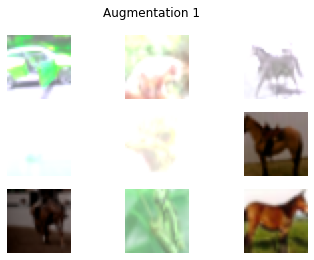

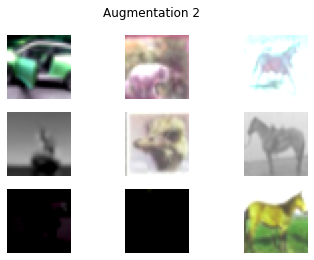

In [6]:
sample_augment_versions = iter(augment_versions)


def plot_values(batch: tuple):
    fig, axs = plt.subplots(3, 3)
    fig1, axs1 = plt.subplots(3, 3)

    fig.suptitle("Augmentation 1")
    fig1.suptitle("Augmentation 2")

    a1, a2 = batch

    # plots images on both tables
    for i in range(3):
        for j in range(3):
            # CHANGE(add / 255)
            axs[i][j].imshow(a1[3 * i + j])
            axs[i][j].axis("off")
            axs1[i][j].imshow(a2[3 * i + j])
            axs1[i][j].axis("off")

    plt.show()


plot_values(next(sample_augment_versions))

In [7]:
class BarlowLoss(keras.losses.Loss):
    """BarlowLoss class.

    BarlowLoss class. Creates a loss function based on the cross-correlation
    matrix.

    Attributes:
        batch_size: the batch size of the dataset
        lambda_amt: the value for lambda(used in cross_corr_matrix_loss)

    Methods:
        __init__: gets instance variables
        call: gets the loss based on the cross-correlation matrix
          make_diag_zeros: Used in calculating off-diagonal section
          of loss function; makes diagonals zeros.
        cross_corr_matrix_loss: creates loss based on cross correlation
          matrix.
    """

    def __init__(self, batch_size: int):
        """__init__ method.

        Gets the instance variables

        Arguments:
            batch_size: An integer value representing the batch size of the
              dataset. Used for cross correlation matrix calculation.
        """

        super(BarlowLoss, self).__init__()
        self.lambda_amt = 5e-3
        self.batch_size = batch_size

    def get_off_diag(self, c: tf.Tensor) -> tf.Tensor:
        """get_off_diag method.

        Makes the diagonals of the cross correlation matrix zeros.
        This is used in the off-diagonal portion of the loss function,
        where we take the squares of the off-diagonal values and sum them.

        Arguments:
            c: A tf.tensor that represents the cross correlation
              matrix

        Returns:
            Returns a tf.tensor which represents the cross correlation
            matrix with its diagonals as zeros.
        """

        zero_diag = tf.zeros(c.shape[-1])
        return tf.linalg.set_diag(c, zero_diag)

    def cross_corr_matrix_loss(self, c: tf.Tensor) -> tf.Tensor:
        """cross_corr_matrix_loss method.

        Gets the loss based on the cross correlation matrix.
        We want the diagonals to be 1's and everything else to be
        zeros to show that the two augmented images are similar.

        Loss function procedure:
        take the diagonal of the cross-correlation matrix, subtract by 1,
        and square that value so no negatives.

        Take the off-diagonal of the cc-matrix(see get_off_diag()),
        square those values to get rid of negatives and increase the value,
        and multiply it by a lambda to weight it such that it is of equal
        value to the optimizer as the diagonal(there are more values off-diag
        then on-diag)

        Take the sum of the first and second parts and then sum them together.

        Arguments:
            c: A tf.tensor that represents the cross correlation
              matrix

        Returns:
            Returns a tf.tensor which represents the cross correlation
            matrix with its diagonals as zeros.
        """

        # subtracts diagonals by one and squares them(first part)
        c_diff = tf.pow(tf.linalg.diag_part(c) - 1, 2)

        # takes off diagonal, squares it, multiplies with lambda(second part)
        off_diag = tf.pow(self.get_off_diag(c), 2) * self.lambda_amt

        # sum first and second parts together
        loss = tf.reduce_sum(c_diff) + tf.reduce_sum(off_diag)

        return loss

    def normalize(self, output: tf.Tensor) -> tf.Tensor:
        """normalize method.

        Normalizes the model prediction.

        Arguments:
            output: the model prediction.

        Returns:
            Returns a normalized version of the model prediction.
        """

        return (output - tf.reduce_mean(output, axis=0)) / tf.math.reduce_std(
            output, axis=0
        )

    def cross_corr_matrix(self, z_a_norm: tf.Tensor, z_b_norm: tf.Tensor) -> tf.Tensor:
        """cross_corr_matrix method.

        Creates a cross correlation matrix from the predictions.
        It transposes the first prediction and multiplies this with
        the second, creating a matrix with shape (n_dense_units, n_dense_units).
        See build_twin() for more info. Then it divides this with the
        batch size.

        Arguments:
            z_a_norm: A normalized version of the first prediction.
            z_b_norm: A normalized version of the second prediction.

        Returns:
            Returns a cross correlation matrix.
        """
        return (tf.transpose(z_a_norm) @ z_b_norm) / self.batch_size

    def call(self, z_a: tf.Tensor, z_b: tf.Tensor) -> tf.Tensor:
        """call method.

        Makes the cross-correlation loss. Uses the CreateCrossCorr
        class to make the cross corr matrix, then finds the loss and
        returns it(see cross_corr_matrix_loss()).

        Arguments:
            z_a: The prediction of the first set of augmented data.
            z_b: the prediction of the second set of augmented data.

        Returns:
            Returns a (rank-0) tf.Tensor that represents the loss.
        """

        z_a_norm, z_b_norm = self.normalize(z_a), self.normalize(z_b)
        c = self.cross_corr_matrix(z_a_norm, z_b_norm)
        loss = self.cross_corr_matrix_loss(c)
        return loss

In [8]:
class ResNet34:
    """Resnet34 class.

        Responsible for the Resnet 34 architecture.
    Modified from
    https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/#h2_2.
    https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/#h2_2.
        View their website for more information.
    """

    def identity_block(self, x, filter):
        # copy tensor to variable called x_skip
        x_skip = x
        # Layer 1
        x = tf.keras.layers.Conv2D(filter, (3, 3), padding="same")(x)
        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        x = tf.keras.layers.Activation("relu")(x)
        # Layer 2
        x = tf.keras.layers.Conv2D(filter, (3, 3), padding="same")(x)
        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        # Add Residue
        x = tf.keras.layers.Add()([x, x_skip])
        x = tf.keras.layers.Activation("relu")(x)
        return x

    def convolutional_block(self, x, filter):
        # copy tensor to variable called x_skip
        x_skip = x
        # Layer 1
        x = tf.keras.layers.Conv2D(filter, (3, 3), padding="same", strides=(2, 2))(x)
        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        x = tf.keras.layers.Activation("relu")(x)
        # Layer 2
        x = tf.keras.layers.Conv2D(filter, (3, 3), padding="same")(x)
        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        # Processing Residue with conv(1,1)
        x_skip = tf.keras.layers.Conv2D(filter, (1, 1), strides=(2, 2))(x_skip)
        # Add Residue
        x = tf.keras.layers.Add()([x, x_skip])
        x = tf.keras.layers.Activation("relu")(x)
        return x

    def __call__(self, shape=(32, 32, 3)):
        # Step 1 (Setup Input Layer)
        x_input = tf.keras.layers.Input(shape)
        x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
        # Step 2 (Initial Conv layer along with maxPool)
        x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(x)
        # Define size of sub-blocks and initial filter size
        block_layers = [3, 4, 6, 3]
        filter_size = 64
        # Step 3 Add the Resnet Blocks
        for i in range(4):
            if i == 0:
                # For sub-block 1 Residual/Convolutional block not needed
                for j in range(block_layers[i]):
                    x = self.identity_block(x, filter_size)
            else:
                # One Residual/Convolutional Block followed by Identity blocks
                # The filter size will go on increasing by a factor of 2
                filter_size = filter_size * 2
                x = self.convolutional_block(x, filter_size)
                for j in range(block_layers[i] - 1):
                    x = self.identity_block(x, filter_size)
        # Step 4 End Dense Network
        x = tf.keras.layers.AveragePooling2D((2, 2), padding="same")(x)
        x = tf.keras.layers.Flatten()(x)
        model = tf.keras.models.Model(inputs=x_input, outputs=x, name="ResNet34")
        return model

In [9]:
def build_twin() -> keras.Model:
    """build_twin method.

    Builds a barlow twins model consisting of an encoder(resnet-34)
    and a projector, which generates embeddings for the images

    Returns:
        returns a barlow twins model
    """

    # number of dense neurons in the projector
    n_dense_neurons = 5000

    # encoder network
    resnet = ResNet34()()
    last_layer = resnet.layers[-1].output

    # intermediate layers of the projector network
    n_layers = 2
    for i in range(n_layers):
        dense = tf.keras.layers.Dense(n_dense_neurons, name=f"projector_dense_{i}")
        if i == 0:
            x = dense(last_layer)
        else:
            x = dense(x)
        x = tf.keras.layers.BatchNormalization(name=f"projector_bn_{i}")(x)
        x = tf.keras.layers.ReLU(name=f"projector_relu_{i}")(x)

    x = tf.keras.layers.Dense(n_dense_neurons, name=f"projector_dense_{n_layers}")(x)

    model = keras.Model(resnet.input, x)
    return model

In [10]:
class BarlowModel(keras.Model):
    """BarlowModel class.

    BarlowModel class. Responsible for making predictions and handling
    gradient descent with the optimizer.

    Attributes:
        model: the barlow model architecture.
        loss_tracker: the loss metric.

    Methods:
        train_step: one train step; do model predictions, loss, and
            optimizer step.
        metrics: Returns metrics.
    """

    def __init__(self):
        super(BarlowModel, self).__init__()
        self.model = build_twin()
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, batch: tf.Tensor) -> tf.Tensor:
        # get the two augmentations from the batch
        y_a, y_b = batch

        with tf.GradientTape() as tape:
            # get two versions of predictions
            z_a, z_b = self.model(y_a, training=True), self.model(y_b, training=True)
            loss = self.loss(z_a, z_b)

        grads_model = tape.gradient(loss, self.model.trainable_variables)

        self.optimizer.apply_gradients(zip(grads_model, self.model.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

97/97 [==============================] - 93s 268ms/step - loss: 3465.8037


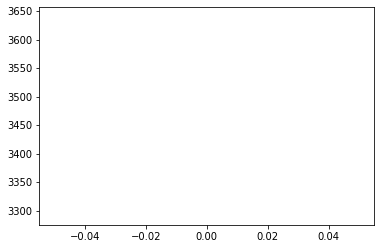

In [11]:
# sets up model, optimizer, loss

bm = BarlowModel()
# chose the LAMB optimizer due to high batch sizes. Converged MUCH faster
# than ADAM or SGD
optimizer = tfa.optimizers.LAMB()
loss = BarlowLoss(BATCH_SIZE)

bm.compile(optimizer=optimizer, loss=loss)

# Expected training time: 1 hours 30 min

history = bm.fit(augment_versions, epochs=1)
plt.plot(history.history["loss"])
plt.show()